### readme - Comentario Notebook experimento MLFlow Versión notebook  

1. Por favor ejecute todo el código 

2. Descripción  
Ejecutamos de un pequeño  modelo de aprendizaje automático que analiza datos médicos para identificar patrones relacionados con el riesgo de sufrir un derrame cerebral

Interactuamos con el MLFlow en el aprendizaje automático donde tenemos:   
- Registro de experimentos: MLFlow guarda cada intento de crear un modelo, con fecha y nombre.
- Seguimiento de parámetros: Registra todas las configuraciones que probamos (como cuántos "árboles" usar en nuestro bosque aleatorio).
- Almacenamiento de métricas: Guarda los resultados (precisión, sensibilidad) para comparar diferentes versiones.
- Visualizaciones: Guarda gráficos que muestran qué características médicas son más importantes para predecir un stroke.
- Gestión de versiones: Permite marcar un modelo como la mejor versión para usarlo en producción

3. para poder ingresar al MLFLow ejecutra [http://localhost:5000](http://localhost:5000/) e ingresar a stroke_prediction del panel Experiments




In [1]:
import mlflow
from datetime import datetime
import awswrangler as wr
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from mlflow import MlflowClient

In [2]:
# Función para graficar la correlación con el target
def plot_correlation_with_target(X_df, y_df):
    # Combinar los dataframes
    combined_df = pd.concat([X_df.reset_index(drop=True), y_df.reset_index(drop=True)], axis=1)
    
    # Calcular la matriz de correlación
    correlation_matrix = combined_df.corr()
    
    # Obtener la correlación con el target (última columna)
    correlation_with_target = correlation_matrix.iloc[:-1, -1].sort_values(ascending=False)
    
    # Crear la figura
    plt.figure(figsize=(10, 8))
    sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)
    plt.title('Correlación de características con Target (stroke)')
    plt.xlabel('Coeficiente de Correlación')
    plt.ylabel('Variables')
    plt.tight_layout()
    
    return plt.gcf()

# Función para graficar la importancia de características
def plot_feature_importance(model, X_df, y_df):
    # Importancia de características
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    
    # Crear la figura
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), np.array(X_df.columns)[sorted_idx])
    plt.title('Importancia de Características (Random Forest)')
    plt.tight_layout()
    
    return plt.gcf()

# Función para obtener o crear un experimento
def get_or_create_experiment(experiment_name):
    # Verificar si el experimento existe
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is not None:
        return experiment.experiment_id
    else:
        # Crear un nuevo experimento si no existe
        experiment_id = mlflow.create_experiment(experiment_name)
        return experiment_id


In [3]:
# Exportar las variables de entorno necesarias para trabajar con Minio
# Export environment variables
%env AWS_ACCESS_KEY_ID=minio   
%env AWS_SECRET_ACCESS_KEY=minio123 
%env MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
%env AWS_ENDPOINT_URL_S3=http://localhost:9000


env: AWS_ACCESS_KEY_ID=minio
env: AWS_SECRET_ACCESS_KEY=minio123
env: MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
env: AWS_ENDPOINT_URL_S3=http://localhost:9000


In [4]:
mlflow_server = "http://localhost:5000"
mlflow.set_tracking_uri(mlflow_server)

In [5]:
# Cargar los datos procesados de Minio
X_train_df = wr.s3.read_csv("s3://data/train/stroke_data_X_train_scaled.csv")
y_train_df = wr.s3.read_csv("s3://data/train/stroke_data_y_train.csv")
X_test_df = wr.s3.read_csv("s3://data/test/stroke_data_X_test_scaled.csv")
y_test_df = wr.s3.read_csv("s3://data/test/stroke_data_y_test.csv")

X_train_df.shape, y_train_df.shape, X_test_df.shape, y_test_df.shape

((3577, 16), (3577, 1), (1533, 16), (1533, 1))

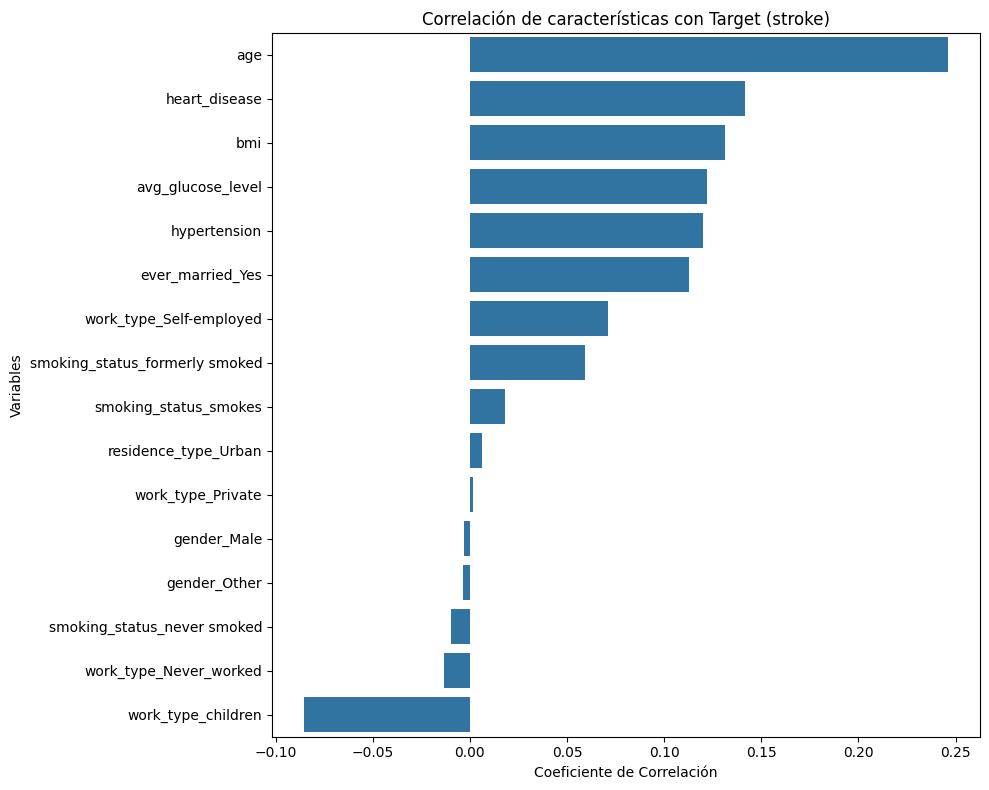

In [6]:
# Testing visualizar la correlación con el target 
corr_plot = plot_correlation_with_target(X_train_df, y_train_df)

# Convertir los dataframes a arrays numpy
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy().ravel()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy().ravel()

In [7]:
# Crear o obtener el ID del experimento para MLflow
experiment_id = get_or_create_experiment("Stroke Prediction")
print(f"Experiment ID: {experiment_id}")

# Definir el nombre de la ejecución para MLflow
run_name_parent = "stroke_prediction_" + datetime.today().strftime('%Y_%m_%d-%H_%M_%S')



Experiment ID: 1


In [8]:
# Mostrar el tamaño de los conjuntos de entrenamiento y prueba
print("Tamaño de los conjuntos:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Tamaño de los conjuntos:
X_train: (3577, 16), y_train: (3577,)
X_test: (1533, 16), y_test: (1533,)


Successfully registered model 'stroke_prediction_model_dev'.
2025/05/03 10:46:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: stroke_prediction_model_dev, version 1
Created version '1' of model 'stroke_prediction_model_dev'.



Resultados del mejor modelo Random Forest:
Accuracy: 0.9400
Precision: 0.3023
Recall: 0.1733
F1 Score: 0.2203
ROC AUC: 0.8360

Mejores parámetros Random Forest: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
🏃 View run stroke_prediction_2025_05_03-10_45_57 at: http://localhost:5000/#/experiments/1/runs/d653829b81d14911b4c2c1216dd6e900
🧪 View experiment at: http://localhost:5000/#/experiments/1


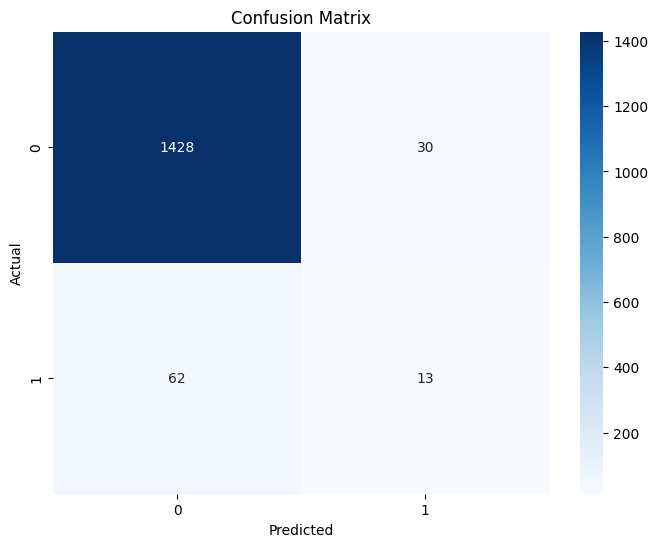

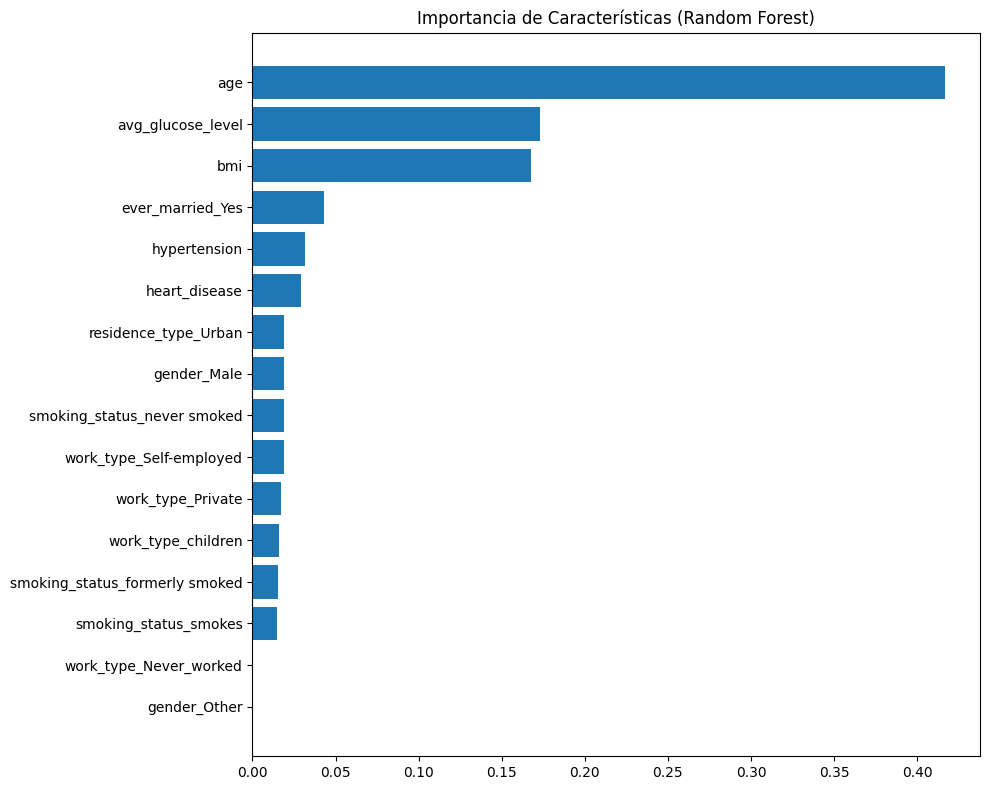

In [9]:
# Definir la cuadrícula de parámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]  # Importante para datasets desbalanceados
}

# Inicializar el modelo Random Forest Classifier (para clasificación)
rf_model = RandomForestClassifier(random_state=42)

# Configurar la búsqueda en cuadrícula con validación cruzada de 5 pliegues
grid_search_rf = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid_rf, 
    cv=5, 
    scoring='roc_auc',  # AUC ROC es una buena métrica para problemas desbalanceados
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Iniciar la ejecución de MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name_parent, nested=True):
    # Realizar la búsqueda en cuadrícula y ajustar el modelo
    grid_search_rf.fit(X_train, y_train)
    
    # Obtener el mejor modelo de la búsqueda en cuadrícula
    best_rf_model = grid_search_rf.best_estimator_
    
    # Realizar predicciones usando el mejor modelo
    rf_predictions_prob = best_rf_model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    rf_predictions = best_rf_model.predict(X_test)  # Predicciones de clase
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, rf_predictions)
    precision = precision_score(y_test, rf_predictions)
    recall = recall_score(y_test, rf_predictions)
    f1 = f1_score(y_test, rf_predictions)
    roc_auc = roc_auc_score(y_test, rf_predictions_prob)
    
    # Crear matriz de confusión
    cm = confusion_matrix(y_test, rf_predictions)
    # -----------------
    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    conf_matrix_plot = plt.gcf()
    
    # Graficar la importancia de las características busca la función plot_feature_importance
    feature_importance_plot = plot_feature_importance(best_rf_model, X_train_df, y_train_df)
    
    # Registrar los mejores parámetros y métricas en MLflow
    mlflow.log_param("best_rf_n_estimators", best_rf_model.n_estimators)
    mlflow.log_param("best_rf_max_depth", best_rf_model.max_depth)
    mlflow.log_param("best_rf_min_samples_split", best_rf_model.min_samples_split)
    mlflow.log_param("best_rf_class_weight", best_rf_model.class_weight)
    
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    
    # Registrar las figuras en MLflow
    mlflow.log_figure(corr_plot, artifact_file="correlation_with_target.png")
    mlflow.log_figure(feature_importance_plot, artifact_file="feature_importance.png")
    mlflow.log_figure(conf_matrix_plot, artifact_file="confusion_matrix.png")
    
    # Obtener un ejemplo de entrada
    input_example = X_test[0:1]
    
    # Definir la ruta del artefacto
    artifact_path = "best_rf_model"
    
    # Inferir el esquema del ejemplo de entrada
    signature = mlflow.models.infer_signature(X_train, best_rf_model.predict_proba(X_train))
    
    # Registrar el mejor modelo Random Forest en el servidor MLflow
    mlflow.sklearn.log_model(
        sk_model=best_rf_model,
        artifact_path=artifact_path,
        signature=signature,
        serialization_format='cloudpickle',
        registered_model_name='stroke_prediction_model_dev',
        metadata={'model_data_version': 1}
    )
    
    # Obtener la URI del modelo registrado
    model_uri = mlflow.get_artifact_uri(artifact_path)
    
    # testing para comparar  resultados en MLFlow
    print("\nResultados del mejor modelo Random Forest:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"\nMejores parámetros Random Forest: {grid_search_rf.best_params_}")

In [10]:
# Probar el modelo
print("\nProbando el modelo cargado...")
loaded_model = mlflow.sklearn.load_model(model_uri)

# Obtener un elemento aleatorio del conjunto de pruebas
random_idx = random.randint(0, X_test.shape[0] - 1)
input_example = X_test[random_idx]
actual_value = y_test[random_idx]

print(f"Ejemplo de entrada seleccionado: {input_example}")
print(f"Valor real: {actual_value}")


Probando el modelo cargado...
Ejemplo de entrada seleccionado: [ 1.41172351 -0.3261943  -0.23881603 -0.25920282  0.44537742  1.1882772
 -0.0167225   0.71766009 -0.05801775 -1.15470054 -0.44398403 -0.39415956
  0.99192525 -0.46280528 -0.76796991 -0.41936993]
Valor real: 0


In [11]:
# Calcular la probabilidad de stroke
stroke_probability = loaded_model.predict_proba(input_example.reshape(1, -1))[0, 1]
predicted_class = loaded_model.predict(input_example.reshape(1, -1))[0]

print(f"Probabilidad de stroke: {stroke_probability:.4f}")
print(f"Clase predicha: {predicted_class}")


Probabilidad de stroke: 0.2382
Clase predicha: 0


In [12]:
# Registrar el modelo para producción
client = MlflowClient()

model_name = "stroke_prediction_model_prod"
desc = "Modelo de producción para la predicción de stroke"

# Verificar si el modelo ya existe, si no, crearlo
try:
    client.get_registered_model(name=model_name)
    print(f"El modelo registrado {model_name} ya existe")
except:
    client.create_registered_model(name=model_name, description=desc)
    print(f"Se ha creado el modelo registrado {model_name}")

# Crear etiquetas para el modelo
tags = best_rf_model.get_params()
tags["model"] = type(best_rf_model).__name__
tags["accuracy"] = accuracy
tags["roc_auc"] = roc_auc

# Crear una nueva versión del modelo
#result = client.create_model_version(
#    name=model_name,
#    source=model_uri,
#    # run_id=mlflow.active_run().info.run_id, # Error ver porque  
#    run_id=run_id,
#    tags=tags
#)
result = client.create_model_version(
    name=model_name,
    source=model_uri,
    run_id=model_uri.split("/")[-3], 
    tags=tags
    ## model_uri tiene un formato como: runs:/run_id/artifacts/artifact_path
    # Al usar split("/") se divide la cadena en partes usando "/" como separado
    # El elemento en la posición -3 (tercero contando desde el final) corresponde al run_id
)



# Establecer la versión actual como "champion"
client.set_registered_model_alias(model_name, "champion", result.version)
print(f"Se ha registrado la versión {result.version} del modelo como 'champion'")

2025/05/03 10:46:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: stroke_prediction_model_prod, version 1


Se ha creado el modelo registrado stroke_prediction_model_prod
Se ha registrado la versión 1 del modelo como 'champion'
